In [16]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
%matplotlib inline

from keras.models import *
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, Cropping2D, concatenate, Activation, Reshape, Permute, Conv1D, Lambda
from keras.activations import softmax
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.utils import np_utils


### Load image data

In [2]:
im_full_stack = io.imread('20171214_MGAN0011_-ROIa2.tif') # 16 slice stack
#im_labels = io.imread('20171214_MGAN0011_-ROIa2-CD3_labels.tif') # 16 slice stack
im_labels2 = io.imread('Labels2.tif') # 
im_test = io.imread('20171214_MGAN0011_-ROIa2-CD3.tif')
im_size = im_labels2[0].shape

im_labels  = im_labels2[0] # labels are 0 - backgrounsd, 1 - intermediate region, 2 - cell
im_weights = im_labels2[1]

# swap the dimentions for keras, so the channels are in the end
im_full_stack = np.moveaxis(im_full_stack, 0, 2)

### Visualize images

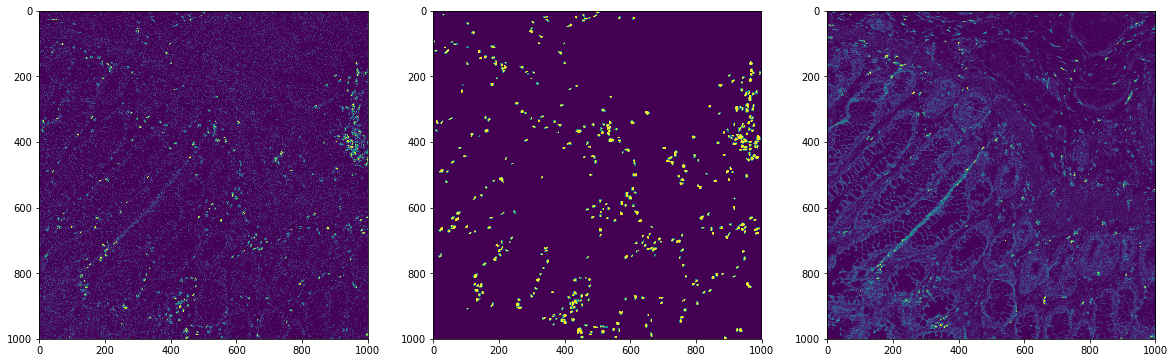

In [3]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
ax1.imshow(im_test)
ax2.imshow(im_labels)
ax3.imshow(im_full_stack[:,:,9])

### Create patches for training 

In [5]:
# randomly generate N patches of size patch_size
N = 3000
patch_size = 112

corner_i = np.random.randint(low = 0, high = im_size[0] - patch_size, size = N)
corner_j = np.random.randint(low = 0, high = im_size[0] - patch_size, size = N)

train_labels = []
train_data = []

Nreal = 0
for i, j in zip (corner_i, corner_j):
        if im_labels[i:i + patch_size, j:j + patch_size].sum() > 700:
            train_labels.append(im_labels[i:i + patch_size, j:j + patch_size])
            train_data.append(im_full_stack[i:i + patch_size, j:j + patch_size, :] / 65535) # normalize the data, does not work without
            Nreal += 1

train_labels = np.asarray(train_labels)
train_data   = np.asarray(train_data)

# convert labes to categorical values one-hot
n_classes = 3
train_labels = np_utils.to_categorical(train_labels, num_classes = n_classes)
train_labels = train_labels.reshape(Nreal, patch_size, patch_size, n_classes)

print (Nreal)

1098


### Data augmentation, rotation and flips

In [6]:
train_data90  = np.rot90(train_data, 1, axes =(1, 2))
train_data180 = np.rot90(train_data, 2, axes =(1, 2))
train_data270 = np.rot90(train_data, 3, axes =(1, 2))

train_labels90  = np.rot90(train_labels, 1, axes =(1, 2))
train_labels180 = np.rot90(train_labels, 2, axes =(1, 2))
train_labels270 = np.rot90(train_labels, 3, axes =(1, 2))

train_flip = np.flip(train_data, 1)
train_flip90  = np.rot90(train_flip, 1, axes =(1, 2))
train_flip180 = np.rot90(train_flip, 2, axes =(1, 2))
train_flip270 = np.rot90(train_flip, 3, axes =(1, 2))

train_labels_flip = np.flip(train_labels, 1)
train_labels_flip90  = np.rot90(train_labels_flip, 1, axes =(1, 2))
train_labels_flip180 = np.rot90(train_labels_flip, 2, axes =(1, 2))
train_labels_flip270 = np.rot90(train_labels_flip, 3, axes =(1, 2))

train_data   = np.concatenate((train_data, train_data90, train_data180, train_data270, train_flip, \
                               train_flip90, train_flip180, train_flip270), axis = 0)
train_labels = np.concatenate((train_labels, train_labels90, train_labels180, train_labels270, \
                               train_labels_flip, train_labels_flip90, train_labels_flip180, \
                               train_labels_flip270), axis = 0)



#f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
#ax1.imshow(testim[1,:,:,6])
#ax2.imshow(train_data90[1,:,:,6])
#ax3.imshow(train_labels90[1,:,:,2])
train_data.shape

(8784, 112, 112, 16)

### Unet

In [7]:
inputs = Input((patch_size, patch_size, 16))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print(conv1.shape)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print(conv2.shape)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print(conv3.shape)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
print(conv4.shape)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
print(conv5.shape)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv11 = Conv2D(n_classes, (1, 1), activation='linear')(conv10)
#print(conv10.shape)

out = Lambda(lambda x: softmax(x, axis = 3))(conv11)

model = Model(inputs=[inputs], outputs=[out])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

(?, 112, 112, 32)
(?, 56, 56, 64)
(?, 28, 28, 128)
(?, 14, 14, 256)
(?, 7, 7, 512)


In [8]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

history = model.fit(train_data, train_labels, batch_size=16, epochs=20, verbose=1, shuffle=True,
              validation_split=0.1,
              callbacks=[model_checkpoint])

Train on 7905 samples, validate on 879 samples
Epoch 1/100
7905/7905 [==============================] - 93s - loss: 0.1103 - acc: 0.9613 - val_loss: 0.0726 - val_acc: 0.9688
Epoch 2/100
7905/7905 [==============================] - 79s - loss: 0.0596 - acc: 0.9744 - val_loss: 0.0631 - val_acc: 0.9736
Epoch 3/100
7905/7905 [==============================] - 78s - loss: 0.0479 - acc: 0.9795 - val_loss: 0.0545 - val_acc: 0.9774
Epoch 4/100
7905/7905 [==============================] - 79s - loss: 0.0375 - acc: 0.9841 - val_loss: 0.0586 - val_acc: 0.9778
Epoch 5/100
7905/7905 [==============================] - 79s - loss: 0.0301 - acc: 0.9873 - val_loss: 0.0485 - val_acc: 0.9812
Epoch 6/100
7905/7905 [==============================] - 80s - loss: 0.0258 - acc: 0.9892 - val_loss: 0.0401 - val_acc: 0.9840
Epoch 7/100
7905/7905 [==============================] - 80s - loss: 0.0228 - acc: 0.9905 - val_loss: 0.0396 - val_acc: 0.9846
Epoch 8/100
7905/7905 [==============================] - 80s - l

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


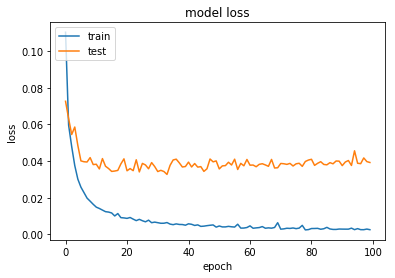

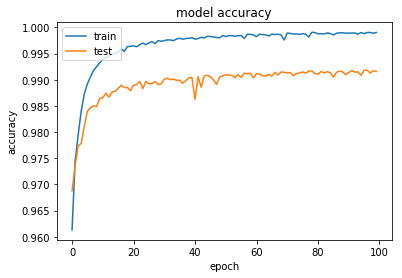

In [9]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### User defined (interesting) patches

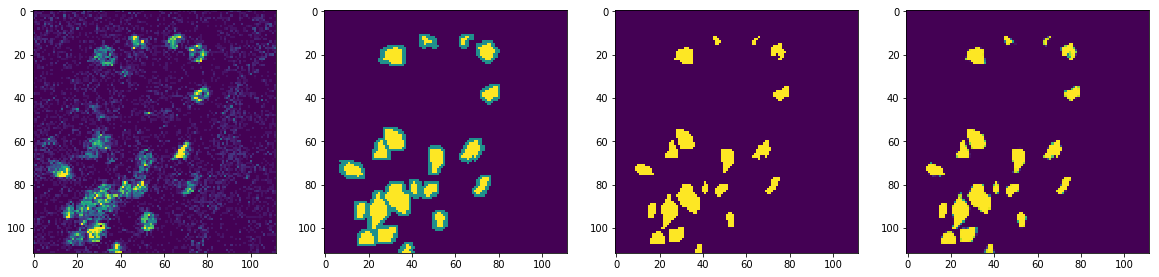

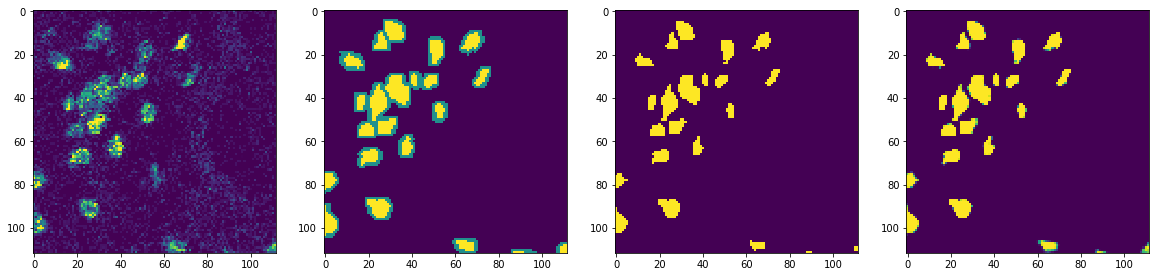

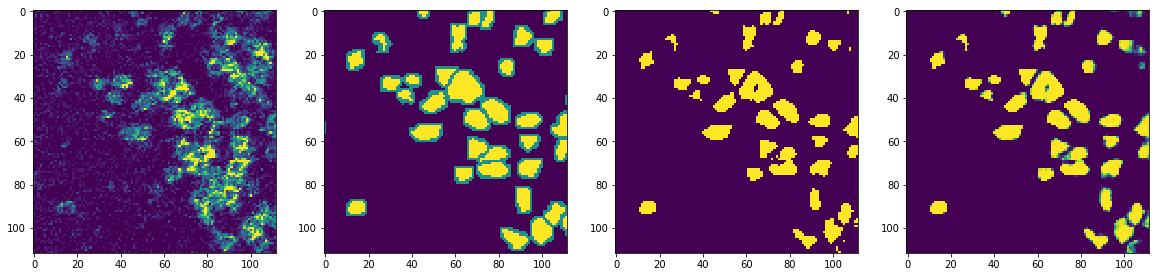

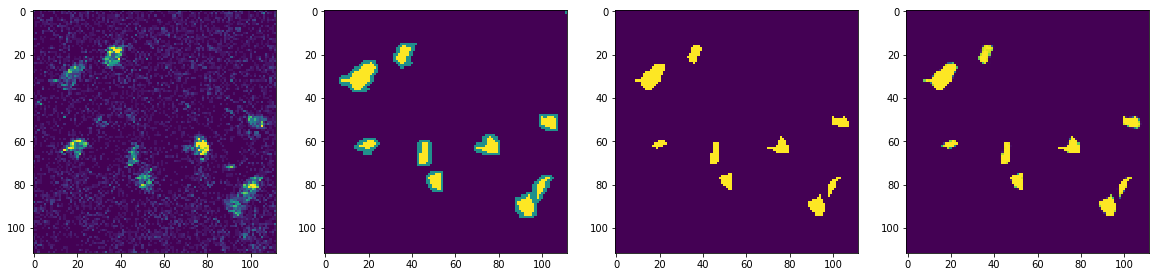

In [15]:
model.load_weights('weights.h5')

main_slice = 6
im1 = im_full_stack[800:800 + patch_size, 400:400 + patch_size, :] /65535
label1 = im_labels[800:800 + patch_size, 400:400 + patch_size] 
im_predict = model.predict(im1.reshape(1, patch_size, patch_size, 16))
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(im1[:,:,main_slice])
ax2.imshow(label1[:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)


im1 = im_full_stack[850:850 + patch_size, 400:400 + patch_size, :] /65535
label1 = im_labels[850:850 + patch_size, 400:400 + patch_size] 
im_predict = model.predict(im1.reshape(1, patch_size, patch_size, 16))
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(im1[:,:,main_slice])
ax2.imshow(label1[:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)


im1 = im_full_stack[350:350 + patch_size, 870:870 + patch_size, :] /65535
label1 = im_labels[350:350 + patch_size, 870:870 + patch_size] 
im_predict = model.predict(im1.reshape(1, patch_size, patch_size, 16))
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(im1[:,:,main_slice])
ax2.imshow(label1[:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)




im1 = im_full_stack[600:600 + patch_size, 800:800 + patch_size, :] /65535
label1 = im_labels[600:600 + patch_size, 800:800 + patch_size] 
im_predict = model.predict(im1.reshape(1, patch_size, patch_size, 16))
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(im1[:,:,main_slice])
ax2.imshow(label1[:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)





### Random patches from the training set

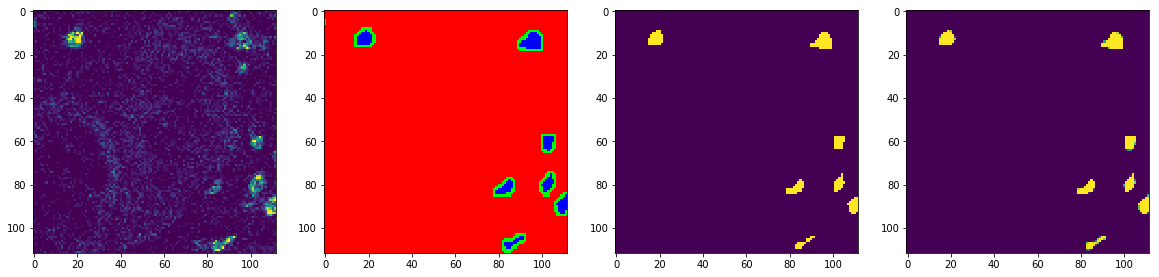

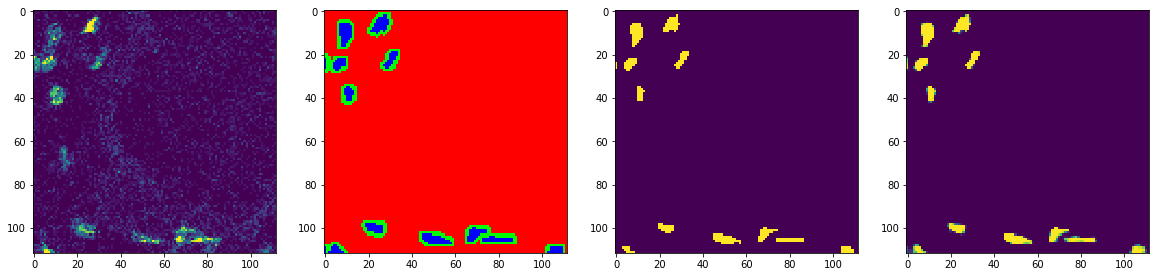

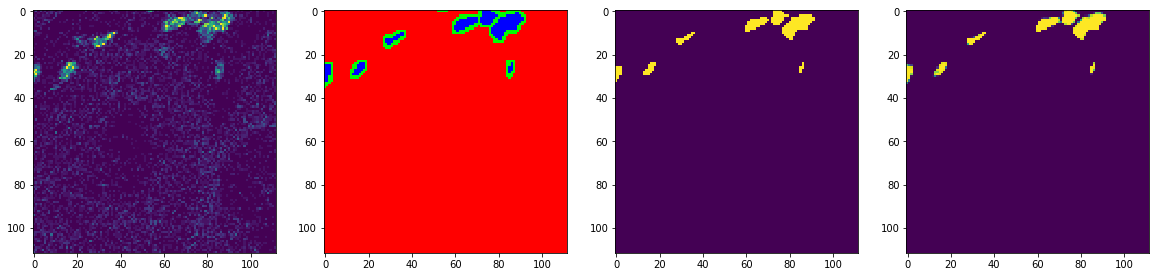

In [11]:
model.load_weights('weights.h5')

main_slice = 6

im_predict = model.predict(train_data[1:2,:,:, :])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[1,:,:,main_slice])
ax2.imshow(train_labels[1,:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)



im_predict = model.predict(train_data[5:6,:,:,:])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[5,:,:,main_slice])
ax2.imshow(train_labels[5,:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)

im_predict = model.predict(train_data[8:9,:,:,:])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[8,:,:,main_slice])
ax2.imshow(train_labels[8,:,:])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)


In [35]:
train_labels.shape

(690, 112, 112, 3)